# Plotting Custom Metric Results


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os

import sae_bench_utils.graphing_utils as graphing_utils

from sae_bench_utils.sae_selection_utils import select_saes_multiple_patterns

/share/u/can/miniconda3/envs/ravel_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This cell is for the following purpose:

Currently, we have a handle of folders, like `absorption` or `core`. In each folder, we have a bunch of tar.gz files. We want a single e.g. `absorption` folder which has a single level and contains all .json results for all SAEs.

To run this, create a folder called `eval_results/` and move `absorption/`, `core/`, etc in to this folder.

In [3]:
# # SAE Bench INTERNAL USE ONLY

# from huggingface_hub import snapshot_download

# hf_repo_id = "adamkarvonen/sae_bench_results"
# local_dir = "./eval_results"
# os.makedirs(local_dir, exist_ok=True)

# snapshot_download(
#     repo_id=hf_repo_id,
#     local_dir=local_dir,
#     repo_type="dataset",
# )

In [4]:
# # SAE Bench INTERNAL USE ONLY

# from huggingface_hub import snapshot_download

# hf_repo_id = "adamkarvonen/sae_bench_results"
# local_dir = "./graphing_eval_results"
# os.makedirs(local_dir, exist_ok=True)

# snapshot_download(
#     repo_id=hf_repo_id,
#     local_dir=local_dir,
#     force_download=True,
#     repo_type="dataset",
#     ignore_patterns=[
#         "*autointerp_with_generations*",
#         "*core_with_feature_statistics*",
#     ],  # These use significant disk space / download time and are not needed for graphing
# )

In [5]:
# # The purpose of this is that we currently organize results like this:

# # {eval_type}/{sae_release}/{sae_release}_{sae_id}_eval_results.json
# # because we have results for over 600 SAEs

# # However, the current scripts output results like this:
# # {eval_type}/{sae_release}_{sae_id}_eval_results.json

# # So, we just flatten the sae bench results to match the expected format

# import os
# import shutil
# import glob
# from pathlib import Path

# # Get all immediate subdirectories in eval_results
# main_dirs = [d for d in os.listdir(local_dir) if os.path.isdir(os.path.join(local_dir, d))]

# for main_dir in main_dirs:
#     main_dir_path = os.path.join(local_dir, main_dir)
#     print(f"\nProcessing {main_dir}...")

#     # Get all subdirectories in the current directory
#     subdirs = [d for d in os.listdir(main_dir_path) if os.path.isdir(os.path.join(main_dir_path, d))]

#     for subdir in subdirs:
#         if not subdir.startswith('.'): # Skip hidden directories
#             subdir_path = os.path.join(main_dir_path, subdir)
#             print(f"Moving files from {subdir}")

#             # Get all files in the subdirectory
#             files = glob.glob(os.path.join(subdir_path, '*'))

#             for file_path in files:
#                 if os.path.isfile(file_path):  # Make sure it's a file, not a directory
#                     file_name = os.path.basename(file_path)
#                     destination = os.path.join(main_dir_path, file_name)

#                     # Handle file name conflicts
#                     if os.path.exists(destination):
#                         base, extension = os.path.splitext(file_name)
#                         counter = 1
#                         while os.path.exists(destination):
#                             new_name = f"{base}_{counter}{extension}"
#                             destination = os.path.join(main_dir_path, new_name)
#                             counter += 1

#                     # Move the file
#                     try:
#                         shutil.move(file_path, destination)
#                         print(f"  Moved: {file_name} -> {os.path.basename(os.path.dirname(destination))}/")
#                     except Exception as e:
#                         print(f"  Error moving {file_name}: {str(e)}")

# print("\nFile moving complete!")

## Load data

Select one of the following `eval_path`, or add your own.

We need a custom eval (SCR, Sparse Probing, etc.) and the core eval results, as we plot the SAEs by L0 / Loss Recovered in most plots.

In [ ]:
local_dir = "./graphing_eval_results"

eval_path = f"{local_dir}/absorption"

core_results_path = f"{local_dir}/core"
image_path = "./images"

if not os.path.exists(image_path):
    os.makedirs(image_path)

Now select SAEs using the regex patterns. Using a list of sae regex patterns allows selecting SAEs using multiple patterns.

This cell stores both the custom eval (e.g. SCR or sparse probing) and the core evals (L0 / Loss Recovered) for every SAE identified by the regex pattern

In [8]:
sae_regex_patterns = [
    r"sae_bench_gemma-2-2b_topk_width-2pow16_date-1109",
    # r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109",
    r"sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109",
    # r"sae_bench_gemma-2-2b_vanilla_width-2pow14_date-1109",
    # r"sae_bench_gemma-2-2b_vanilla_width-2pow12_date-1109",
    r"(gemma-scope-2b-pt-res)",
    # r'gemma-2-2b_layer_5_additivity'
]

layer = 12

# Include checkpoints (not relevant to Gemma-Scope)
# sae_block_pattern = [
#     # rf".*blocks\.{layer}.*",
#     rf".*blocks\.{layer}.*",
#     rf".*blocks\.{layer}.*",
# ]

# Exclude checkpoints
sae_block_patterns = [
    # rf".*blocks\.{layer}(?!.*step).*",
    # rf".*blocks\.{layer}(?!.*step).*",
    rf".*blocks\.{layer}(?!.*step).*",
    rf".*blocks\.{layer}(?!.*step).*",
    rf".*layer_({layer}).*(16k).*",  # For Gemma-Scope
    # rf'.*',
]


assert len(sae_regex_patterns) == len(sae_block_patterns)

selected_saes = select_saes_multiple_patterns(sae_regex_patterns, sae_block_patterns)


eval_results = graphing_utils.get_eval_results(selected_saes, eval_path)
core_results = graphing_utils.get_core_results(selected_saes, core_results_path)

for sae in eval_results:
    eval_results[sae].update(core_results[sae])

100%|██████████| 57/57 [00:00<00:00, 117308.80it/s]

Selected SAEs from releases: {'sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109', 'gemma-scope-2b-pt-res', 'sae_bench_gemma-2-2b_topk_width-2pow16_date-1109'}
Sample SAEs: sae_bench_gemma-2-2b_topk_width-2pow16_date-1109, blocks.12.hook_resid_post__trainer_0
Sample SAEs: sae_bench_gemma-2-2b_topk_width-2pow16_date-1109, blocks.12.hook_resid_post__trainer_1
Sample SAEs: sae_bench_gemma-2-2b_topk_width-2pow16_date-1109, blocks.12.hook_resid_post__trainer_2
Sample SAEs: sae_bench_gemma-2-2b_topk_width-2pow16_date-1109, blocks.12.hook_resid_post__trainer_3
Sample SAEs: sae_bench_gemma-2-2b_topk_width-2pow16_date-1109, blocks.12.hook_resid_post__trainer_4
Sample SAEs: sae_bench_gemma-2-2b_topk_width-2pow16_date-1109, blocks.12.hook_resid_post__trainer_5
Sample SAEs: sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109, blocks.12.hook_resid_post__trainer_0
Sample SAEs: sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109, blocks.12.hook_resid_post__trainer_1
Sample SAEs: sae_bench_gemma-2-2

In [10]:
sae_names = list(eval_results.keys())

print(eval_results.keys())
print("\nAvailable SAEs:\n", eval_results.keys())

dict_keys([])

Available SAEs:
 dict_keys([])


For plotting purposes we also want dictionary size, sae type, and number of training steps. The following cell populates this information.

## Plot custom metric above unsupervised metrics


In [11]:
print("\nAvailable custom metrics:\n", eval_results[sae_names[0]].keys())

IndexError: list index out of range

In [12]:
k = None
k = 2

custom_metric, custom_metric_name = graphing_utils.get_custom_metric_key_and_name(eval_path, k)

if "tpp" in eval_path:
    custom_metric = f"tpp_threshold_{k}_total_metric"
    custom_metric_name = f"TPP Top {k} Metric"
elif "scr" in eval_path:
    custom_metric = f"scr_metric_threshold_{k}"
    custom_metric_name = f"SCR Top {k} Metric"
elif "sparse_probing" in eval_path:
    custom_metric = f"sae_top_{k}_test_accuracy"
    custom_metric_name = f"Sparse Probing Top {k} Test Accuracy"
elif "absorption" in eval_path:
    custom_metric = "mean_absorption_score"
    custom_metric_name = "Mean Absorption Score"
elif "autointerp" in eval_path:
    custom_metric = "autointerp_score"
    custom_metric_name = "Autointerp Score"
else:
    raise ValueError("Please add the correct key for the custom metric")

image_base_name = os.path.join(image_path, custom_metric)
print(custom_metric, custom_metric_name)

mean_absorption_score Mean Absorption Score


ValueError: min() arg is an empty sequence

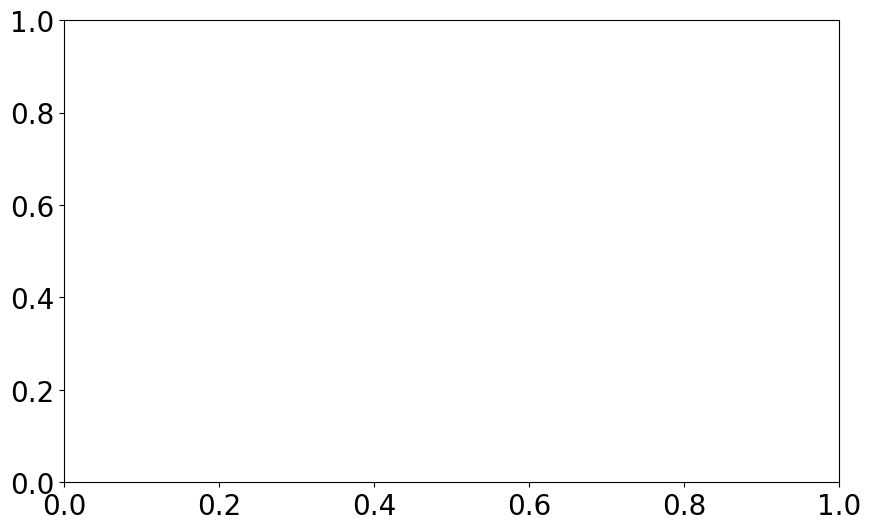

In [13]:
title_3var = f"L0 vs Loss Recovered vs {custom_metric_name}"
title_2var = f"L0 vs {custom_metric_name}"

graphing_utils.plot_3var_graph(
    eval_results,
    title_3var,
    custom_metric,
    colorbar_label="Custom Metric",
    output_filename=f"{image_base_name}_3var.png",
)
graphing_utils.plot_2var_graph(
    eval_results,
    custom_metric,
    y_label=custom_metric_name,
    title=title_2var,
    output_filename=f"{image_base_name}_2var.png",
)
# plot_interactive_3var_graph(plotting_results, custom_metric)

# At this point, if there's any additional .json files located alongside the ae.pt and eval_results.json
# You can easily adapt them to be included in the plotting_results dictionary by using something similar to add_ae_config_results()

### ...with interactive hovering


In [ ]:
# graphing_utils.plot_interactive_3var_graph(
#     eval_results,
#     custom_metric,
#     title=title_3var,
#     output_filename=f"{image_base_name}_3var_interactive.html",
# )

In [ ]:
graphing_utils.plot_2var_graph_dict_size(
    eval_results,
    custom_metric,
    y_label=custom_metric_name,
    title=title_2var,
    output_filename=f"{image_base_name}_2var.png",
)

## Plot metric over training checkpoints


Note: We have SAE checkpoints at initialization (step 0), which does not fit on
a log scale (log(0) = -inf). We visualize this with a cut in the graph.

In [ ]:
# graphing_utils.plot_training_steps(
#     eval_results,
#     custom_metric,
#     title=f"Tokens vs {custom_metric_name} Gemma Layer {layer}",
#     output_filename=f"{image_base_name}_tokens_vs_diff.png",
# )

This cell combines all of the above steps into a single function so we can plot results from multiple runs.

In [ ]:
eval_path = f"{local_dir}/unlearning"
eval_path = f"{local_dir}/scr"
eval_path = f"{local_dir}/sparse_probing"
# eval_path = f"{local_dir}/tpp"
# eval_path = f"{local_dir}/absorption"

core_results_path = f"{local_dir}/core"
for layer in [5, 12, 19]:
    sae_regex_patterns = [
        # r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109",
        # r"sae_bench_gemma-2-2b_topk_width-2pow14_date-1109",/
        r"sae_bench_gemma-2-2b_topk_width-2pow16_date-1109",
        r"sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109",
        # r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109",
        # r"sae_bench_gemma-2-2b_vanilla_width-2pow14_date-1109",
        # r"sae_bench_gemma-2-2b_vanilla_width-2pow12_date-1109",
        r"(gemma-scope-2b-pt-res)",
    ]

    sae_block_pattern = [
        # rf".*blocks\.{layer}(?!.*step).*",
        # rf".*blocks\.{layer}(?!.*step).*",
        # rf".*blocks\.{layer}(?!.*step).*",
        rf".*blocks\.{layer}(?!.*step).*",
        # rf".*blocks\.{layer}(?!.*step).*",
        rf".*blocks\.{layer}(?!.*step).*",
        # rf".*layer_({layer}).*(16k).*", # For Gemma-Scope
        rf".*layer_({layer}).*(65k).*",  # For Gemma-Scope
    ]

    sae_regex_patterns = [
        r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109",
        r"sae_bench_gemma-2-2b_topk_width-2pow14_date-1109",
        r"sae_bench_gemma-2-2b_topk_width-2pow16_date-1109",
        # r"sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109",
        # r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109",
        # r"sae_bench_gemma-2-2b_vanilla_width-2pow14_date-1109",
        # r"sae_bench_gemma-2-2b_vanilla_width-2pow12_date-1109",
        # r"(gemma-scope-2b-pt-res)",
    ]

    sae_block_pattern = [
        # rf".*blocks\.{layer}(?!.*step).*",
        # rf".*blocks\.{layer}(?!.*step).*",
        # rf".*blocks\.{layer}(?!.*step).*",
        rf".*blocks\.{layer}(?!.*step).*",
        rf".*blocks\.{layer}(?!.*step).*",
        rf".*blocks\.{layer}(?!.*step).*",
        # rf".*layer_({layer}).*(16k).*", # For Gemma-Scope
        # rf".*layer_({layer}).*(65k).*", # For Gemma-Scope
    ]

    # Include checkpoints
    # sae_block_pattern = [
    # rf".*blocks\.{layer}.*",
    # rf".*blocks\.{layer}.*",
    # ]

    selected_saes = select_saes_multiple_patterns(sae_regex_patterns, sae_block_pattern)

    graphing_utils.plot_results(selected_saes, eval_path, core_results_path, image_base_name, k=1)

# SAE Bench Plot Generator

In [ ]:
import itertools
import os

from sae_bench_utils.sae_selection_utils import select_saes_multiple_patterns
import sae_bench_utils.graphing_utils as graphing_utils

selections = {
    "Gemma-Scope Gemma-2-2B Width Series": [
        [
            r"(gemma-scope-2b-pt-res)",
        ],
        [
            r".*layer_{layer}.*(16k|65k|1m).*",
        ],
    ],
    "Gemma-Scope Gemma-2-9B Width Series": [
        [
            r"(gemma-scope-9b-pt-res)",
        ],
        [
            r".*layer_{layer}.*(16k|131k|1m).*",
        ],
    ],
    "SAE Bench Gemma-2-2B TopK Width Series": [
        [
            r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109",
            r"sae_bench_gemma-2-2b_topk_width-2pow14_date-1109",
            r"sae_bench_gemma-2-2b_topk_width-2pow16_date-1109",
        ],
        [
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
        ],
    ],
    "SAE Bench Gemma-2-2B Vanilla Width Series": [
        [
            r"sae_bench_gemma-2-2b_vanilla_width-2pow12_date-1109",
            r"sae_bench_gemma-2-2b_vanilla_width-2pow14_date-1109",
            r"sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109",
        ],
        [
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
        ],
    ],
    "SAE Bench Gemma-2-2B 4K Width Series": [
        [
            r"sae_bench_gemma-2-2b_vanilla_width-2pow12_date-1109",
            r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109",
        ],
        [
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
        ],
    ],
    "SAE Bench Gemma-2-2B 16K Width Series": [
        [
            r"sae_bench_gemma-2-2b_vanilla_width-2pow14_date-1109",
            r"sae_bench_gemma-2-2b_topk_width-2pow14_date-1109",
            r"(gemma-scope-2b-pt-res)",
        ],
        [
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
            r".*layer_{layer}.*(16k).*",
        ],
    ],
    "SAE Bench Gemma-2-2B 65K Width Series": [
        [
            r"sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109",
            r"sae_bench_gemma-2-2b_topk_width-2pow16_date-1109",
            r"(gemma-scope-2b-pt-res)",
        ],
        [
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
            r".*layer_{layer}.*(65k).*",
        ],
    ],
    "SAE Bench Pythia-70M SAE Type Series": [
        [
            r"sae_bench_pythia70m_sweep.*_ctx128_.*",
        ],
        [r".*blocks\.({layer})\.hook_resid_post__trainer_.*"],
    ],
}

eval_path = f"{local_dir}/unlearning"
eval_path = f"{local_dir}/scr"
eval_path = f"{local_dir}/sparse_probing"
# eval_path = f"{local_dir}/tpp"
# eval_path = f"{local_dir}/absorption"

eval_paths = [
    f"{local_dir}/sparse_probing",
    f"{local_dir}/tpp",
    f"{local_dir}/scr",
    f"{local_dir}/core",
    f"{local_dir}/absorption",
    f"{local_dir}/autointerp",
    f"{local_dir}/unlearning",
]

core_results_path = f"{local_dir}/core"

combinations = list(itertools.product(eval_paths, selections.keys()))

ks_lookup = {
    "scr": [10, 50, 500],
    "tpp": [10, 50, 500],
    "sparse_probing": [1, 2, 5],
}

for eval_path, selection in combinations:
    eval_type = eval_path.split("/")[-1]

    if eval_type in ks_lookup:
        ks = ks_lookup[eval_type]
    else:
        ks = [-1]

    if "Gemma-2-2B" in selection:
        layers = [5, 12, 19]
    elif "Pythia-70M" in selection:
        layers = [3, 4]
    elif "Gemma-2-9B" in selection:
        layers = [9, 20, 31]
    else:
        raise ValueError("Please add the correct layers for the selection")

    layer_ks_combinations = list(itertools.product(layers, ks))

    for layer, k in layer_ks_combinations:
        sae_regex_patterns = selections[selection][0]
        sae_block_patterns = list(selections[selection][1])

        for i, pattern in enumerate(sae_block_patterns):
            sae_block_patterns[i] = pattern.format(layer=layer)

        prefix = f"{selection} Layer {layer}\n"

        image_base_folder = os.path.join(image_path, eval_type)

        if not os.path.exists(image_base_folder):
            os.makedirs(image_base_folder)

        image_base_name = os.path.join(
            image_base_folder, f"{selection.replace(' ', '_').lower()}_layer_{layer}"
        )

        if eval_type in ks_lookup:
            image_base_name = f"{image_base_name}_topk_{k}"

        selected_saes = select_saes_multiple_patterns(sae_regex_patterns, sae_block_patterns)

        # We will have failures on e.g. Pythia and unlearning, because the results don't exist
        try:
            graphing_utils.plot_results(
                selected_saes,
                eval_path,
                core_results_path,
                image_base_name,
                k=k,
                title_prefix=prefix,
            )
        except Exception as e:
            print(f"Error plotting {selection} Layer {layer}: {str(e)}")
            continue

In [ ]:
 import itertools
import os

from sae_bench_utils.sae_selection_utils import select_saes_multiple_patterns
import sae_bench_utils.graphing_utils as graphing_utils

selections = {
    "Gemma-Scope Gemma-2-2B Width Series": [
        [
            r"(gemma-scope-2b-pt-res)",
        ],
        [
            r".*layer_{layer}.*(16k|65k|1m).*",
        ],
    ],
    "Gemma-Scope Gemma-2-9B Width Series": [
        [
            r"(gemma-scope-9b-pt-res)",
        ],
        [
            r".*layer_{layer}.*(16k|131k|1m).*",
        ],
    ],
    "SAE Bench Gemma-2-2B TopK Width Series": [
        [
            r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109",
            r"sae_bench_gemma-2-2b_topk_width-2pow14_date-1109",
            r"sae_bench_gemma-2-2b_topk_width-2pow16_date-1109",
        ],
        [
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
        ],
    ],
    "SAE Bench Gemma-2-2B Vanilla Width Series": [
        [
            r"sae_bench_gemma-2-2b_vanilla_width-2pow12_date-1109",
            r"sae_bench_gemma-2-2b_vanilla_width-2pow14_date-1109",
            r"sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109",
        ],
        [
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
            r".*blocks\.{layer}(?!.*step).*",
        ],
    ],
}

eval_paths = [
    # f"{local_dir}/sparse_probing",
    # f"{local_dir}/tpp",
    f"{local_dir}/scr",
]

core_results_path = f"{local_dir}/core"

combinations = list(itertools.product(eval_paths, selections.keys()))

ks_lookup = {
    "scr": [10, 50, 100, 500],
    "tpp": [10, 50, 100, 500],
    "sparse_probing": [1, 2, 5, 10, 50],
}

best_of_image_path = "./images/best_of"

for eval_path, selection in combinations:
    eval_type = eval_path.split("/")[-1]

    if eval_type in ks_lookup:
        ks = ks_lookup[eval_type]
    else:
        raise ValueError("This cell is only meant for SCR, TPP, and Sparse Probing")

    if "Gemma-2-2B" in selection:
        layers = [5, 12, 19]
    elif "Pythia-70M" in selection:
        layers = [3, 4]
    elif "Gemma-2-9B" in selection:
        layers = [9, 20, 31]
    else:
        raise ValueError("Please add the correct layers for the selection")

    for layer in layers:
        sae_regex_patterns = selections[selection][0]
        sae_block_patterns = list(selections[selection][1])

        for i, pattern in enumerate(sae_block_patterns):
            sae_block_patterns[i] = pattern.format(layer=layer)

        prefix = f"{selection} Layer {layer}\n"

        image_base_folder = os.path.join(best_of_image_path, eval_type)

        if not os.path.exists(image_base_folder):
            os.makedirs(image_base_folder)

        image_base_name = os.path.join(
            image_base_folder, f"{selection.replace(' ', '_').lower()}_layer_{layer}"
        )

        if eval_type in ks_lookup:
            image_base_name = f"{image_base_name}_topk_{str(ks)}"

        selected_saes = select_saes_multiple_patterns(sae_regex_patterns, sae_block_patterns)

        # We will have failures on e.g. Pythia and unlearning, because the results don't exist
        try:
            graphing_utils.plot_best_of_ks_results(
                selected_saes,
                eval_path,
                core_results_path,
                image_base_name,
                ks=ks,
                title_prefix=prefix,
            )
        except Exception as e:
            print(f"Error plotting {selection} Layer {layer}: {str(e)}")
            continue

In [ ]:
import itertools
import os

from sae_bench_utils.sae_selection_utils import select_saes_multiple_patterns
import sae_bench_utils.graphing_utils as graphing_utils

checkpoint_selections = {
    # r"sae_bench_gemma-2-2b_topk_width-2pow12_date-1109": r".*blocks\.{layer}.*",
    "gemma-2-2b 16k": [
        [
            r"sae_bench_gemma-2-2b_topk_width-2pow14_date-1109",
            r"sae_bench_gemma-2-2b_vanilla_width-2pow14_date-1109",
        ],
        [r".*blocks\.{layer}.*", r".*blocks\.{layer}.*"],
    ],
    # r"sae_bench_gemma-2-2b_topk_width-2pow16_date-1109": r".*blocks\.{layer}.*",
    # r"sae_bench_gemma-2-2b_vanilla_width-2pow12_date-1109": r".*blocks\.{layer}.*",
    # r"sae_bench_gemma-2-2b_vanilla_width-2pow16_date-1109": r".*blocks\.{layer}.*",
}

eval_paths = [
    f"{local_dir}/sparse_probing",
    f"{local_dir}/tpp",
    f"{local_dir}/scr",
    f"{local_dir}/absorption",
    f"{local_dir}/unlearning",
    f"{local_dir}/autointerp",
]

core_results_path = f"{local_dir}/core"

combinations = list(itertools.product(eval_paths, checkpoint_selections.keys()))

ks_lookup = {
    "scr": [10, 50],
    "tpp": [10, 50],
    "sparse_probing": [1, 2, 5],
}

checkpoint_image_path = "./checkpoint_images"

for eval_path, selection in combinations:
    eval_type = eval_path.split("/")[-1]

    if eval_type in ks_lookup:
        ks = ks_lookup[eval_type]
    else:
        ks = [-1]

    if "gemma-2-2b" in selection:
        layers = [5, 12, 19]
    else:
        raise ValueError("Please add the correct layers for the selection")

    layer_ks_combinations = list(itertools.product(layers, ks))

    for layer, k in layer_ks_combinations:
        print(selection)

        sae_regex_patterns = checkpoint_selections[selection][0]
        sae_block_patterns = list(checkpoint_selections[selection][1])

        for i, pattern in enumerate(sae_block_patterns):
            sae_block_patterns[i] = pattern.format(layer=layer)

        prefix = f"{selection} Layer {layer}\n"

        image_base_folder = os.path.join(checkpoint_image_path, eval_type)

        if not os.path.exists(image_base_folder):
            os.makedirs(image_base_folder)

        image_base_name = os.path.join(
            image_base_folder, f"{selection.replace(' ', '_').lower()}_layer_{layer}"
        )

        if eval_type in ks_lookup:
            image_base_name = f"{image_base_name}_topk_{k}"

        selected_saes = select_saes_multiple_patterns(sae_regex_patterns, sae_block_patterns)

        eval_results = graphing_utils.get_eval_results(selected_saes, eval_path)
        core_results = graphing_utils.get_core_results(selected_saes, core_results_path)

        # if len(eval_results) != len(selected_saes):
        #     print(f"Skipping {selection} Layer {layer} due to missing results")
        #     continue

        for sae in eval_results:
            eval_results[sae].update(core_results[sae])

        custom_metric, custom_metric_name = graphing_utils.get_custom_metric_key_and_name(
            eval_path, k
        )

        graphing_utils.plot_training_steps(
            eval_results,
            custom_metric,
            title=f"Tokens vs {custom_metric_name} Gemma Layer {layer}",
            output_filename=f"{image_base_name}_tokens_vs_diff.png",
        )

        break

## Plot metric correlations


In [ ]:
# k=100
# custom_metric = f'sae_top_{k}_test_accuracy'

metric_keys = [
    "l0",
    "frac_recovered",
    custom_metric,
]

graphing_utils.plot_correlation_heatmap(eval_results, metric_names=metric_keys, ae_names=None)

In [ ]:
# Simple example usage:
# plot_metric_scatter(plotting_results, metric_x="l0", metric_y="frac_recovered", title="L0 vs Fraction Recovered")

threshold_x = 50
threshold_y = 100

metric_x = f"sae_top_{threshold_x}_test_accuracy"
metric_y = f"sae_top_{threshold_y}_test_accuracy"

title = f""
x_label = "k=1 Sparse Probe Accuracy"
y_label = "k=100 Sparse Probe Accuracy"
output_filename = os.path.join(
    image_path,
    f"sparse_probing_result_correlation_for_thresholds_{threshold_y}_{threshold_y}.png",
)

graphing_utils.plot_correlation_scatter(
    eval_results,
    metric_x=metric_x,
    metric_y=metric_y,
    title=title,
    x_label=x_label,
    y_label=y_label,
    output_filename=output_filename,
)